# Customer Segmentation for Online Retail - techniques

This is an example of the segmentation techniques. 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler,  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [3]:
# Get the current working directory
current_directory = os.getcwd()

# Correctly join the path to the data file, relative to the script's location
file_path = os.path.join(current_directory, "../data", "customers.csv")

## The dataset

In [4]:
#pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [5]:
# Fetch dataset
online_retail = fetch_ucirepo(id=352)

# Data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# Convert targets to a dataframe if it's not already
if not isinstance(y, pd.DataFrame):
    y = pd.DataFrame(y, columns=["target"])

# Concatenate features and targets into a single dataframe
df = pd.concat([X, y], axis=1)

In [6]:
# Display the first few rows of the combined dataframe
df.head()

# Metadata
#print(online_retail.metadata)

# Variable information
#print(online_retail.variables)

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,target
0,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,NaN
1,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN
2,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,NaN
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN
4,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,NaN


In [7]:
# Save the dataframe to the specified file path 
df.to_csv(file_path, index=False) 
print(f"Dataframe saved to {file_path}")

Dataframe saved to C:\Users\darya\Documents\Simplon\ML and Zoo\scripts\../data\customers.csv


In [8]:
df.dtypes

Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
target          object
dtype: object

### Variables

- **Description:** This column contains the name of the product being purchased. For example, "WHITE HANGING HEART T-LIGHT HOLDER".
- **Quantity:** The number of items being purchased in a single transaction. For example, 6 units of "WHITE HANGING HEART T-LIGHT HOLDER".
- **InvoiceDate:** The date and time of the transaction. The format is "MM/DD/YYYY HH:MM".
- **UnitPrice:** The price per unit of the product. For instance, the "WHITE HANGING HEART T-LIGHT HOLDER" costs 2.55 currency units each.
- **CustomerID:** A unique identifier for the customer making the purchase. For example, the customer ID 17850.
- **Country:** The country where the customer is located.

## Phase 1: Data Exploration

Begin by thoroughly exploring the dataset to understand its structure, the types of data it contains, and any initial patterns. This includes examining summary statistics, visualizing distributions, and identifying any anomalies or missing values.

In [88]:
# Define column names and types
column_names = ["Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country", "target"]
column_types = {
    "Description": "string",
    "Quantity": "float",
    "InvoiceDate": "string",  # Temporary read as string to parse date format later
    "UnitPrice": "float",
    "CustomerID": "string",
    "Country": "string",
    "target": "string"
}

# Read the CSV file
df = pd.read_csv(file_path, names=column_names, dtype=column_types, skiprows=1)
df.dtypes

Description    string[python]
Quantity              float64
InvoiceDate    string[python]
UnitPrice             float64
CustomerID     string[python]
Country        string[python]
target         string[python]
dtype: object

**The new name for "target" is "profile"**

In [89]:
df.rename(columns={"target": "profile"}, inplace=True)

## Phase 2: Data Preprocessing
Prepare the data for analysis by cleaning it. This involves handling missing values, removing duplicates. Ensure the data is in a suitable format for the next steps.

### 2.1. Handling Missing Values 

In [90]:
# Remove rows with missing CustomerID and InvoiceDate
df = df.dropna(subset=["CustomerID", "InvoiceDate"])

# Sort rows by InvoiceDate in descending order
df = df.sort_values(by="InvoiceDate", ascending=False)

# Filter rows where Country is not 'Unspecified' and Description is not empty
df = df[(df["Country"] != "Unspecified") & (df["Country"].notna())]
df = df[(df["Description"] != "") & (df["Description"].notna())]

# Parse InvoiceDate as datetime, inferring format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])#,infer_datetime_format=True
df.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,profile
332571,FRIDGE MAGNETS LES ENFANTS ASSORTED,24.0,2011-09-09 09:52:00,0.85,17593.0,United Kingdom,<NA>
332536,HANGING MINI COLOURED BOTTLES,96.0,2011-09-09 09:52:00,0.63,17593.0,United Kingdom,<NA>
332551,MAGNETS PACK OF 4 RETRO PHOTO,24.0,2011-09-09 09:52:00,0.39,17593.0,United Kingdom,<NA>
332550,MAGNETS PACK OF 4 HOME SWEET HOME,24.0,2011-09-09 09:52:00,0.39,17593.0,United Kingdom,<NA>
332549,FRENCH LATTICE CUSHION COVER,12.0,2011-09-09 09:52:00,0.85,17593.0,United Kingdom,<NA>


In [91]:
# Check for missing values 
print(df.isnull().sum()) 

Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID          0
Country             0
profile        406585
dtype: int64


### 2.2. Removing duplicates

In [92]:
# Count the number of duplicate rows 
duplicate_count = df.duplicated().sum() 
# Print the number of duplicate rows 
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 5298


In [93]:
# Remove duplicate rows
df = df.drop_duplicates()

# Verify that duplicates have been removed
duplicate_count_after = df.duplicated().sum()
print(f"Number of duplicate rows after removing: {duplicate_count_after}")


Number of duplicate rows after removing: 0


### 2.3. Data Formats

In [94]:
df.dtypes

Description    string[python]
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID     string[python]
Country        string[python]
profile        string[python]
dtype: object

In [95]:
# Split into date and time
df["InvTime"] = df["InvoiceDate"].dt.time
df["InvDate"] = df["InvoiceDate"].dt.date
df["InvHour"] = df["InvoiceDate"].dt.hour
# Display the resulting dataframe
df.head()

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,profile,InvTime,InvDate,InvHour
332571,FRIDGE MAGNETS LES ENFANTS ASSORTED,24.0,2011-09-09 09:52:00,0.85,17593.0,United Kingdom,<NA>,09:52:00,2011-09-09,9
332536,HANGING MINI COLOURED BOTTLES,96.0,2011-09-09 09:52:00,0.63,17593.0,United Kingdom,<NA>,09:52:00,2011-09-09,9
332551,MAGNETS PACK OF 4 RETRO PHOTO,24.0,2011-09-09 09:52:00,0.39,17593.0,United Kingdom,<NA>,09:52:00,2011-09-09,9
332550,MAGNETS PACK OF 4 HOME SWEET HOME,24.0,2011-09-09 09:52:00,0.39,17593.0,United Kingdom,<NA>,09:52:00,2011-09-09,9
332549,FRENCH LATTICE CUSHION COVER,12.0,2011-09-09 09:52:00,0.85,17593.0,United Kingdom,<NA>,09:52:00,2011-09-09,9


## Phase 3: Feature Engineering
Create the key variables needed for customer segmentation:

- **Frequency: The number of times a customer has made a purchase.**
- **Recency: The number of days since the customer's last purchase.**
- **Monetary: The total amount of money spent by the customer.**

### 3.1. Additional variables

In [96]:
df["Amount"]=df["Quantity"]*df["UnitPrice"]
# Create a new variable sureIndex
df["sureIndex"] = df["Amount"].apply(lambda x: -1 if x < 0 else 1 if x > 0 else 0)

### 3.2. FRM-analysis

In [97]:
sureIndMean=df.groupby("CustomerID")["sureIndex"].median().reset_index()
sureIndMean.columns = ["CustomerID", "NonCancellationRate"]

In [98]:
# Compute RFM (Recency, Frequency, Monetary) values for each customer
# Use the last date in the dataframe as the current date

current_date = df["InvoiceDate"].max()

df["LastOrder"]=(current_date-df["InvoiceDate"]).dt.days
last_order_mean=df.groupby("CustomerID")["LastOrder"].min().reset_index()
last_order_mean.columns=["CustomerID","Recency"]
last_order_mean['RecencyScore'] = np.log1p(last_order_mean['Recency'])

first_order_mean=df.groupby("CustomerID")["LastOrder"].max().reset_index()
first_order_mean.columns=["CustomerID","Tenure"]
first_order_mean['TenureScore'] = np.log1p(first_order_mean['Tenure'])

last_order_mean=last_order_mean.merge(first_order_mean, on="CustomerID")
last_order_mean.head()

,CustomerID,Recency,RecencyScore,Tenure,TenureScore
0,12346.0,325,5.786897,325,5.786897
1,12347.0,1,0.693147,366,5.905362
2,12348.0,74,4.317488,357,5.880533
3,12349.0,18,2.944439,18,2.944439
4,12350.0,309,5.736572,309,5.736572


In [99]:
# plt.figure(figsize=(8, 6)) 
# sns.scatterplot(x='RecencyScore', y='RecencyScore', data=last_order_mean) 
# plt.xlabel('Recency Score') 
# plt.ylabel('Customer Tenure (days)') 
# plt.title('Scatter Plot of Recency Score vs Customer Tenure')

In [100]:
# Calculate the sum of amounts for each customer
amount_sums = df.groupby("CustomerID")["Amount"].sum().reset_index()
amount_sums.columns = ["CustomerID", "Monetary"]

In [101]:
order_counts = df.groupby("CustomerID")["InvoiceDate"].nunique().reset_index() 
order_counts.columns = ["CustomerID", "Frequency"]

In [102]:
order_country = df.groupby("CustomerID")["Country"].unique().reset_index() 
order_country.columns = ["CustomerID", "Country"]

In [103]:
order_hour = df.groupby("CustomerID")["InvHour"].mean().reset_index()
order_hour.columns = ["CustomerID", "Hour"]

In [104]:
# Apply the function to get only the first value from the StringArray representation
order_country['Country'] = order_country['Country'].apply(lambda x: x[0] if isinstance(x, (list, pd.arrays.StringArray)) else x)

# Display the modified dataframe
order_country.astype(str)


,CustomerID,Country
0,12346.0,United Kingdom
1,12347.0,Iceland
2,12348.0,Finland
3,12349.0,Italy
4,12350.0,Norway
...,...,...
4363,18280.0,United Kingdom
4364,18281.0,United Kingdom
4365,18282.0,United Kingdom
4366,18283.0,United Kingdom


In [105]:
# Merge order counts and amount sums with the original dataframe 
# Merge dataframes to create the clients dataframe 
RFM = sureIndMean.merge(last_order_mean, on="CustomerID")
RFM = RFM.merge(amount_sums, on="CustomerID")
RFM = RFM.merge(order_counts, on="CustomerID")
RFM = RFM.merge(order_country, on="CustomerID")
RFM = RFM.merge(order_hour, on="CustomerID")
######################## New Features #########################################################################
#Customer Lifetime Value (CLV)
RFM['CLV'] = RFM['Monetary'] * RFM['Frequency']
#RFM Score
RFM['RFMScore'] = RFM['Recency'] * RFM['Frequency'] * RFM['Monetary']
#Spend Frequency Ratio
RFM['SpendFrequencyRatio'] = RFM['Frequency'] / (RFM['Recency'] + 1)
# High-Value Customers Indicator
threshold_monetary = RFM['Monetary'].quantile(0.75)
threshold_frequency = RFM['Frequency'].quantile(0.75)
RFM['HighValueCustomer'] = (RFM['Monetary'] > threshold_monetary) & (RFM['Frequency'] > threshold_frequency)
################################################################################################################
RFM = RFM[RFM['TenureScore'].between(RFM['TenureScore'].quantile(0.05), RFM['TenureScore'].quantile(0.99))]


RFM.columns
#RFM.shape

Index(['CustomerID', 'NonCancellationRate', 'Recency', 'RecencyScore',
       'Tenure', 'TenureScore', 'Monetary', 'Frequency', 'Country', 'Hour',
       'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer'],
      dtype='object')

<Axes: xlabel='TenureScore'>

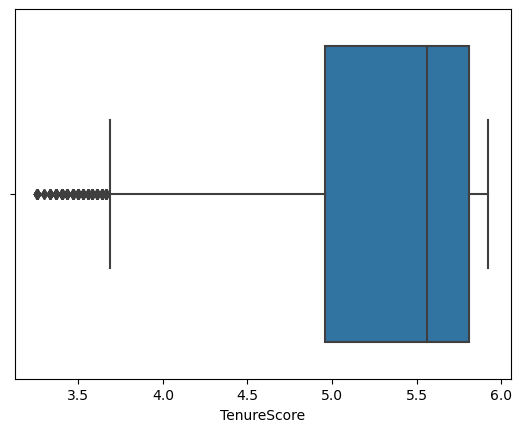

In [106]:
sns.boxplot(x='TenureScore',data=RFM)

### 3.3. Data Cleaning

In [107]:
# Get unique countries
RFM = RFM[RFM['Country'] != 'European Community']
unique_countries = RFM['Country'].unique()

# Create a mapping from countries to integers
country_to_int = {country: idx for idx, country in enumerate(unique_countries)}

# Apply the mapping to the Country column
RFM['CountryInt'] = RFM['Country'].map(country_to_int)

In [108]:
# Create a mapping of countries to continents
country_to_continent = {
    'United Kingdom': 'Europe', 'Iceland': 'Europe', 'Finland': 'Europe', 'Italy': 'Europe',
    'Norway': 'Europe', 'Spain': 'Europe', 'Portugal': 'Europe', 'Switzerland': 'Europe',
    'Austria': 'Europe', 'Cyprus': 'Europe', 'Belgium': 'Europe', 'Denmark': 'Europe',
    'France': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 'Sweden': 'Europe',
    'Poland': 'Europe', 'Netherlands': 'Europe', 'Czech Republic': 'Europe', 'EIRE': 'Europe',
    'Channel Islands': 'Europe', 'Lithuania': 'Europe', 'Malta': 'Europe',
    'Bahrain': 'Asia', 'Israel': 'Asia', 'Saudi Arabia': 'Asia', 'United Arab Emirates': 'Asia',
    'Singapore': 'Asia', 'Japan': 'Asia', 'Lebanon': 'Asia',
    'USA': 'North America', 'Canada': 'North America',
    'Brazil': 'South America',
    'Australia': 'Oceania',
    'RSA': 'Africa'
}

# Apply the mapping to create a new 'Continent' column
RFM['Continent'] = RFM['Country'].map(country_to_continent)

# Create a mapping of continents to integer codes
continent_to_int = {
    'Europe': 0, 
    'Asia': 1, 
    'North America': 2, 
    'South America': 2, 
    'Oceania': 3, 
    'Africa': 3
}

# Apply the mapping to create a new 'ContinentInt' column
RFM['ContinentInt'] = RFM['Continent'].map(continent_to_int)


## Phase 4: Dimensionality Reduction
If needed, apply dimensionality reduction techniques such as Principal Component Analysis (PCA) to reduce the complexity of the data while retaining important information. This step can help improve the efficiency and effectiveness of the clustering algorithms.

In [109]:
# Exclude non-numeric columns
numeric_cols = ['NonCancellationRate', 'RecencyScore',
        'TenureScore', 'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer']
#df_numeric = RFM_filtered[numeric_cols]
df_numeric = RFM[numeric_cols]

In [110]:
df_numeric.corr()

,NonCancellationRate,RecencyScore,TenureScore,CLV,RFMScore,SpendFrequencyRatio,HighValueCustomer
NonCancellationRate,1.000000,-0.116640,-0.032011,0.008719,0.016876,0.017524,0.057120
RecencyScore,-0.116640,1.000000,0.081153,-0.133215,-0.011974,-0.320025,-0.466335
TenureScore,-0.032011,0.081153,1.000000,0.062033,0.095176,0.100937,0.311654
CLV,0.008719,-0.133215,0.062033,1.000000,0.289162,0.669725,0.145506
RFMScore,0.016876,-0.011974,0.095176,0.289162,1.000000,0.031193,0.185837
SpendFrequencyRatio,0.017524,-0.320025,0.100937,0.669725,0.031193,1.000000,0.257457
HighValueCustomer,0.057120,-0.466335,0.311654,0.145506,0.185837,0.257457,1.000000


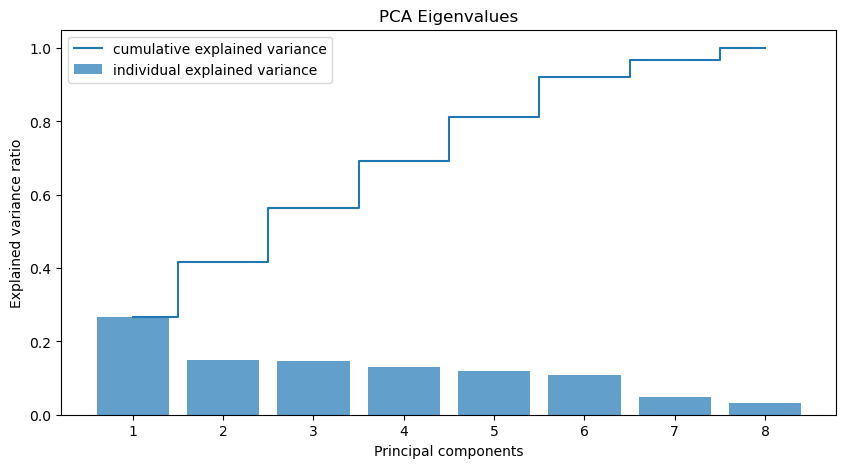

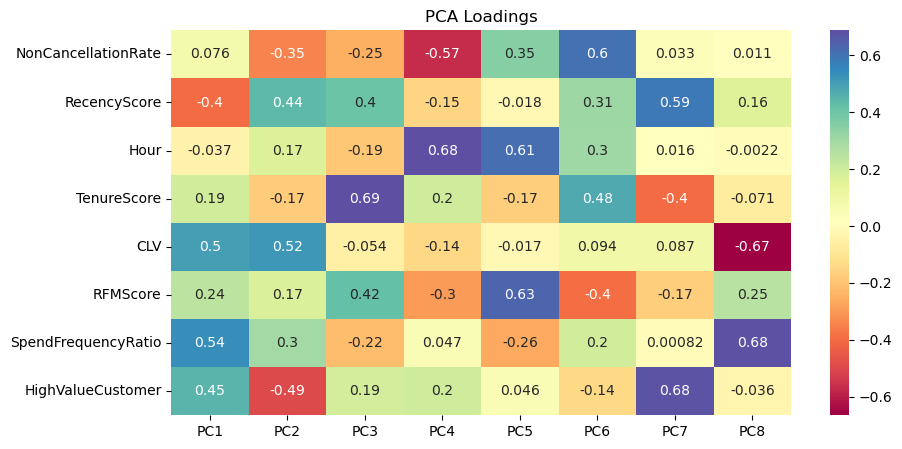

In [112]:
# Exclude non-numeric columns
numeric_cols = ['NonCancellationRate', 'RecencyScore','Hour',
        'TenureScore', 'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer']
#df_numeric = RFM_filtered[numeric_cols]
df_numeric = RFM[numeric_cols]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

# Create a dataframe for the PCA data
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(len(numeric_cols))])

# Extract the eigenvalues
eigenvalues = pca.explained_variance_ratio_

# Plot the eigenvalues
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, align='center', label='individual explained variance')
plt.step(range(1, len(eigenvalues) + 1), np.cumsum(eigenvalues), where='mid', label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.title('PCA Eigenvalues')
plt.show()

# Plot the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(numeric_cols))], index=numeric_cols)
plt.figure(figsize=(10, 5))
sns.heatmap(loadings, annot=True, cmap='Spectral')
plt.title('PCA Loadings')
plt.show()

pca_df.head()

# Include PCA values in the original dataframe 
RFM_PCA = pd.concat([RFM, pca_df], axis=1)

### Conclusions: 
The correlations are generally weak to moderate, indicating that while there are some relationships between the features, they are not strong. Given this, dimensionality reduction (e.g., using PCA) might not be necessary unless you aim for more refined analysis or visualization purposes. The existing features seem to capture distinct aspects of customer behavior, which can be useful for detailed segmentation and analysis.

## Phase 5: Application of Unsupervised Learning Techniques
Use clustering algorithms like K-means, Hierarchical Clustering, or DBSCAN to segment the customers. These techniques will group customers based on their purchasing behaviors and the features engineered in Phase 3.

### 5.1. K-means for "RFM"

In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Data for analysis
col=['NonCancellationRate', 'RecencyScore', 'Hour',
        'TenureScore', 'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer']
RFM_Kmeans = RFM[col]

# Split the data into training and test sets
train_data, test_data = train_test_split(RFM_Kmeans, test_size=0.2, random_state=42)

# Standardize the training data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[col])

# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
K = range(2, 11)  # Start from 2 as silhouette score is not defined for 1 cluster

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data_scaled)
    silhouette_scores.append(silhouette_score(train_data_scaled, kmeans.labels_))

# Choose the optimal number of clusters (based on the highest silhouette score)
optimal_clusters = K[np.argmax(silhouette_scores)]
print('Optimal number of clusters is ', optimal_clusters)

# Train the K-means model with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
train_data['Cluster'] = kmeans.fit_predict(train_data_scaled)

# Standardize the test data
test_data_scaled = scaler.transform(test_data[col])

# Predict clusters for test data
test_data['Cluster'] = kmeans.predict(test_data_scaled)

# Evaluate the model
# Compute silhouette score
test_silhouette_avg = silhouette_score(test_data_scaled, test_data['Cluster'])
print(f'Test Silhouette Score: {test_silhouette_avg}')

# Compute Davies-Bouldin Index
test_davies_bouldin = davies_bouldin_score(test_data_scaled, test_data['Cluster'])
print(f'Test Davies-Bouldin Index: {test_davies_bouldin}')

# Compute Calinski-Harabasz Index
test_calinski_harabasz = calinski_harabasz_score(test_data_scaled, test_data['Cluster'])
print(f'Test Calinski-Harabasz Index: {test_calinski_harabasz}')


Optimal number of clusters is  2
Test Silhouette Score: 0.4243073067948806
Test Davies-Bouldin Index: 1.2467950084685744
Test Calinski-Harabasz Index: 143.06463686217566


#### Silhouette Score: 0.29
* Interpretation: A silhouette score of around 0.3 suggests that the clusters are somewhat overlapping and less distinct. While this is not an ideal score, it indicates that there is some structure in the data, but improvements can be made to enhance the cluster separation.
#### Davies-Bouldin Index: 0.99
Interpretation: The Davies-Bouldin Index measures the average similarity ratio of each cluster with its most similar cluster. Lower values are better, and your score of 0.994 suggests reasonable separation between clusters. However, there is some room for improvement.
#### Calinski-Harabasz Index: 208.42
Interpretation: The Calinski-Harabasz Index measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters. Your score of 208.421 indicates moderately well-defined clusters, but there might be some within-cluster variance that could be reduced.

**Summary:**
clustering model has identified some structure in the data with 4 clusters. The scores indicate that while the clusters are reasonably well-defined, there is still some overlap and variance within the clusters. **You might consider further tuning the model or exploring other clustering methods to improve the clustering quality.If you're satisfied with these results, you can proceed with further analysis or application of these clusters.**

### 5.2. Hierarchical Clustering

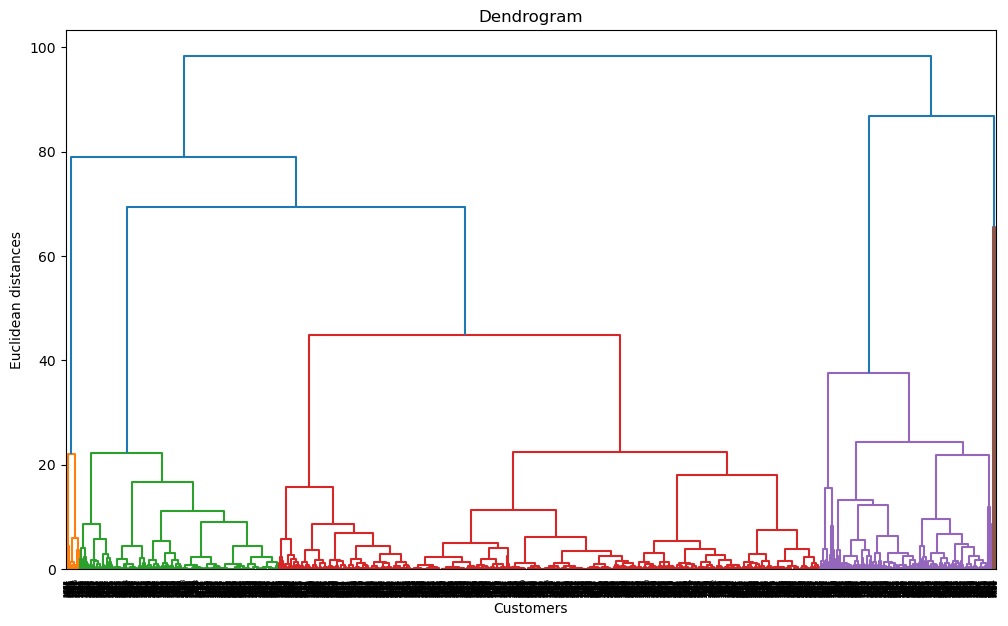

Test Silhouette Score: 0.49920548069158943
Test Davies-Bouldin Index: 0.5629646247456401
Test Calinski-Harabasz Index: 637.8131338293582


In [117]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import scipy.cluster.hierarchy as sch


# Data for analysis
col = ['NonCancellationRate', 'RecencyScore',
        'TenureScore', 'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer']
RFM_Kmeans = RFM[col]


# Split the data into training and test sets
train_data, test_data = train_test_split(RFM_Kmeans, test_size=0.2, random_state=42)

# Standardize the training data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[col])

# Create the Dendrogram to find the optimal number of clusters
plt.figure(figsize=(12, 7))
dendrogram = sch.dendrogram(sch.linkage(train_data_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

# Based on the dendrogram, assume the optimal number of clusters is 4
optimal_clusters = 4 # You may adjust this based on the dendrogram visualization

# Train the Hierarchical Clustering model
hc = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
train_data['Cluster'] = hc.fit_predict(train_data_scaled)

# Standardize the test data
test_data_scaled = scaler.transform(test_data[col])

# Predict clusters for test data
test_data['Cluster'] = hc.fit_predict(test_data_scaled)

# Evaluate the model
# Compute silhouette score
test_silhouette_avg = silhouette_score(test_data_scaled, test_data['Cluster'])
print(f'Test Silhouette Score: {test_silhouette_avg}')

# Compute Davies-Bouldin Index
test_davies_bouldin = davies_bouldin_score(test_data_scaled, test_data['Cluster'])
print(f'Test Davies-Bouldin Index: {test_davies_bouldin}')

# Compute Calinski-Harabasz Index
test_calinski_harabasz = calinski_harabasz_score(test_data_scaled, test_data['Cluster'])
print(f'Test Calinski-Harabasz Index: {test_calinski_harabasz}')


### Initial results
#### Silhouette Score: 0.27
* Interpretation: A silhouette score of approximately 0.27 indicates that the clusters are not very well separated and there is substantial overlap. This suggests that the clustering model has difficulty distinguishing between different data points and that the clusters may not be very distinct.
#### Davies-Bouldin Index: 1.04
* Interpretation: The Davies-Bouldin Index measures the average similarity ratio of each cluster with its most similar cluster. Lower values are better, and your score of 1.046 suggests that the clusters are reasonably separated but could be improved. A value close to 1 indicates some degree of overlap between clusters.
#### Calinski-Harabasz Index: 231.17
* Interpretation: he Calinski-Harabasz Index measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters. Your score of 231.177 is moderate, suggesting that the clusters have some structure but there is room for improvement.

**Summary:**
clustering model has identified some structure in the data with 6 clusters. **You might consider further tuning the model or exploring other clustering methods to improve the clustering quality.If you're satisfied with these results, you can proceed with further analysis or application of these clusters.**

### 5.3. DBSCAN clustering

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Data for analysis
col = ['NonCancellationRate', 'RecencyScore',
        'TenureScore', 'CLV', 'RFMScore', 'SpendFrequencyRatio', 'HighValueCustomer']
RFM_DBSCAN = RFM[col]

# Split the data into training and test sets
train_data, test_data = train_test_split(RFM_DBSCAN, test_size=0.2, random_state=42)

# Standardize the training data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data[col])
test_data_scaled = scaler.transform(test_data[col])

# Train the DBSCAN model
dbscan = DBSCAN(eps=2.75, min_samples=40)  # You may need to tune these parameters based on your data
train_data['Cluster'] = dbscan.fit_predict(train_data_scaled)

# Predict clusters for test data
test_data['Cluster'] = dbscan.fit_predict(test_data_scaled)

# Filter out noise points labeled as -1
train_data_clusters = train_data[train_data['Cluster'] != -1]
test_data_clusters = test_data[test_data['Cluster'] != -1]

# Evaluate the model on the test set without noise
# Compute silhouette score
if len(set(test_data['Cluster'])) > 1:
    test_silhouette_avg = silhouette_score(test_data_scaled, test_data['Cluster'])
    test_davies_bouldin = davies_bouldin_score(test_data_scaled, test_data['Cluster'])
    test_calinski_harabasz = calinski_harabasz_score(test_data_scaled, test_data['Cluster'])
else:
    test_silhouette_avg = -1
    test_davies_bouldin = -1
    test_calinski_harabasz = -1

print(f'Test Silhouette Score: {test_silhouette_avg}')
print(f'Test Davies-Bouldin Index: {test_davies_bouldin}')
print(f'Test Calinski-Harabasz Index: {test_calinski_harabasz}')


Test Silhouette Score: 0.7891888431254359
Test Davies-Bouldin Index: 1.855233070702428
Test Calinski-Harabasz Index: 99.55314052533849


**Summary:** 
* Silhouette Score: Indicates well-defined and reasonably separated clusters.
* Davies-Bouldin Index: Suggests moderate separation between clusters with some overlap.
* Calinski-Harabasz Index: Confirms that the clusters are distinguishable but can be improved.